# Rakan's Playground




## Setup

### General

In [55]:
!pip install spotipy

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import sys
PROJECT_ROOT = '/content/drive/My Drive/UofT/4th Year/APS360/Project/Hit-Song-Prediction/'
sys.path.append(PROJECT_ROOT)

In [58]:
from SpotifyConnection import get_spotify_connection
import Playlist as PL
from DataProcessing import normalize_dataframe, DataInformation, SpotifyTracksDataset, normalize_data_by_type, normalize_data

In [59]:
sp = get_spotify_connection()

In [60]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

### PyTorch

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [62]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [63]:
import random

def seed_torch(seed=0):
  random.seed(seed)

  np.random.seed(seed)
  np.random.RandomState(seed)

  torch.manual_seed(seed) 
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) #seed all gpus    
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.enabled = False  
  torch.backends.cudnn.benchmark = False

seed_torch(0)

## Loading Data

In [64]:
DataInformation.list()

['duration',
 'key',
 'mode',
 'time_signature',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'valence',
 'tempo',
 'artist_popularity',
 'popularity']

In [65]:
pl = PL.load_playlist(PROJECT_ROOT + "playlist_2sRZldX6n9oaII70OoO3zB")

Loaded playlist from file: /content/drive/My Drive/UofT/4th Year/APS360/Project/Hit-Song-Prediction/playlist_2sRZldX6n9oaII70OoO3zB


In [12]:
dataset = SpotifyTracksDataset(normalized_df)
dataset_small = SpotifyTracksDataset(normalized_df.iloc[0:100])

In [13]:
dataset_tiny = SpotifyTracksDataset(normalized_df.iloc[0:10])

In [146]:
num_data = normalized_df.shape[0]
num_train = int(num_data*0.01)
num_val = int(num_data*0.01)
num_test = num_data - num_train - num_val

train = SpotifyTracksDataset(normalized_df.iloc[0:num_train])
val = SpotifyTracksDataset(normalized_df.iloc[num_train:num_train+num_val])
test = SpotifyTracksDataset(normalized_df.iloc[num_train+num_val:num_data])

## Exploring Data

In [12]:
import matplotlib.pyplot as plt

In [13]:
def plot_feature_and_target(df, feature):
  cols = [feature, DataInformation.TARGET]
  df = df[cols]

  df.plot.scatter(x=feature, y=DataInformation.TARGET)
  return

In [67]:
features = DataInformation.Feature.list()
features.remove(DataInformation.Feature.KEY.value)
features.remove(DataInformation.Feature.MODE.value)
features.remove(DataInformation.Feature.TIME_SIGNATURE.value)

target = DataInformation.TARGET

cols = features + [target]

df = pl.get_playlist_df()

df.duration = df.duration / 1000
df.duration = normalize_data_by_type(df.duration, DataInformation.NormalizationType.STD_CLAMP)
df.tempo = normalize_data_by_type(df.tempo, DataInformation.NormalizationType.DEFAULT)
df.loudness = normalize_data_by_type(df.loudness, DataInformation.NormalizationType.DEFAULT)
df.artist_popularity = normalize_data(df.loudness, data_min=0, data_max=1)


df.head()


,id,name,popularity,duration,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,artist_popularity,release_date,explicit
0,0q75NwOoFiARAVp4EXU4Bs,Love Galore (feat. Travis Scott),76,0.635764,0,1,4,0.1110,0.795,0.594,0.0,0.1620,0.858757,0.0747,0.409,0.616788,0.858757,2017-06-09,True
1,593W4qZOwwdqF6YnimJjL6,Doves In The Wind (feat. Kendrick Lamar),63,0.601991,10,0,4,0.3430,0.692,0.713,0.0,0.1020,0.896666,0.3510,0.615,0.627561,0.896666,2017-06-09,True
2,6gU9OKjOE7ghfEd55oRO57,The Weekend,75,0.624904,8,0,5,0.2410,0.487,0.366,0.0,0.1260,0.787748,0.0531,0.161,0.311547,0.787748,2017-06-09,True
3,23wcL7jlwSLVZ54V1qO7oO,Plot Twist,28,0.455992,8,1,5,0.1270,0.590,0.652,0.0,0.0626,0.865515,0.3350,0.691,0.569657,0.865515,2017-06-30,True
4,7FYH5AW3bVfZHJIQpq3UOA,I Don't Fuck With You,75,0.670685,1,1,4,0.0355,0.824,0.733,0.0,0.3240,0.874820,0.0613,0.393,0.447603,0.874820,2015-02-24,True


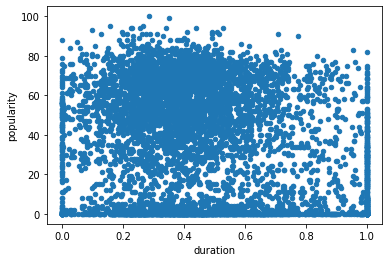

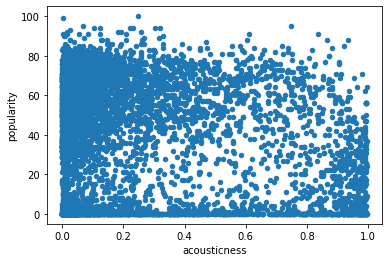

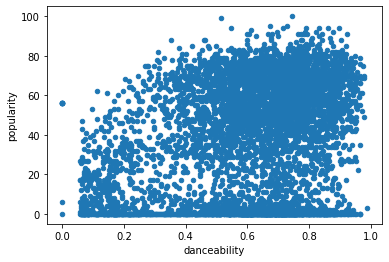

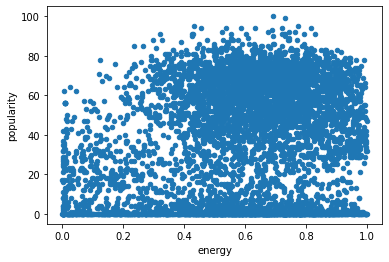

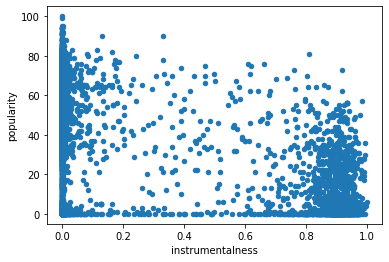

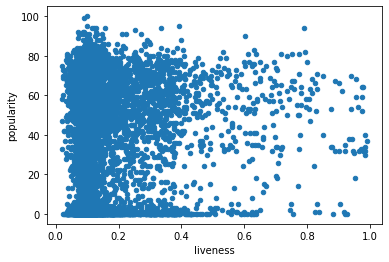

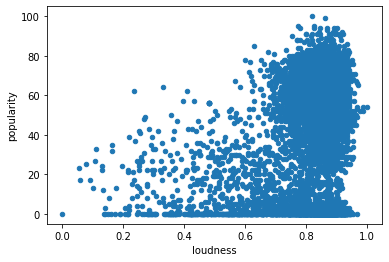

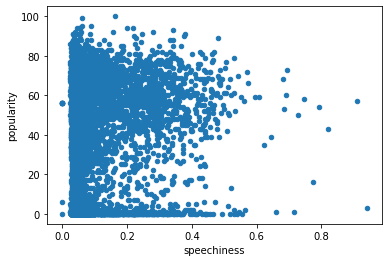

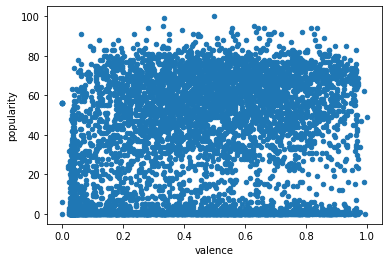

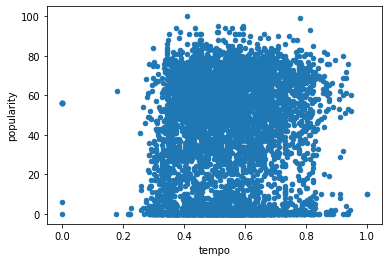

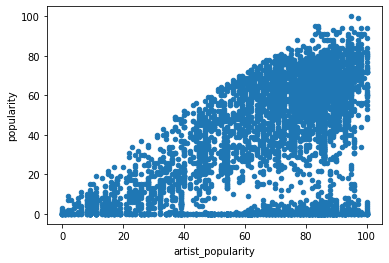

In [31]:

for feature in features:
  plot_feature_and_target(df, feature)

### Creating Dataset

In [50]:
num_data = df.shape[0]

num_train = int(num_data*0.005)
num_val = int(num_data*0.005)
num_test = num_data - num_train - num_val

train = SpotifyTracksDataset(df.iloc[0:num_train], features, target)
val = SpotifyTracksDataset(df.iloc[num_train:num_train+num_val], features, target)
test = SpotifyTracksDataset(df.iloc[num_train+num_val:num_data], features, target)

## Model

In [36]:
class TestNet(nn.Module):
  def __init__(self):
    super(TestNet, self).__init__()
    
    self.layers = nn.Sequential(
        nn.Linear(11, 20),
        nn.ReLU(),
        nn.Linear(20,10),
        nn.ReLU(),
        nn.Linear(10,1)
    ).to(device)


  def forward(self, x):
    x = self.layers(x)
    return x

## Training

### Helper Functions

In [17]:
def get_error(model, data):
  data_loader = torch.utils.data.DataLoader(data, batch_size=100)

  total_error = 0
  for features, targets in data_loader:
    features = features.to(device)
    targets = targets.to(device)

    out = model(features)
    total_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()
  
  error_rate = total_error/len(data)
  return error_rate

In [18]:
def predict_some(model, data, num_to_predict):
  for i in range(0, num_to_predict):
    features, target = data[i]
    features = features.to(device)
    target = target.to(device)

    out = model(features.unsqueeze(0)).clamp(min=0,max=100)
    print(f"Actual: {round(target.item(), 2)};  Predicted: {round(out.item(), 2)}")

### Train Function

In [19]:
def train_net(model, train_data, valid_data, bs=50, lr=0.01, wd=0, epochs=5):
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)

  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

  for epoch in range(1, epochs + 1):
    epoch_error = 0
    epoch_loss = 0.0
    for i, batch in enumerate(train_loader, 1):
      features, targets = batch

      features = features.to(device)
      targets = targets.to(device)
      
      optimizer.zero_grad()
      out = model(features)
      
      loss = criterion(out, targets)
      loss.backward()
      optimizer.step()


      epoch_loss += loss.item()
      epoch_error += (targets - out.clamp(min=0,max=100)).abs().sum().item()

    epoch_loss = epoch_loss / i
    train_error_rate = epoch_error / len(train_data)
    val_error_rate = get_error(model, valid_data)
    
    print(f"Epoch {epoch}")
    print(f"  Train Error: {train_error_rate}")
    print(f"  Valid Error: {val_error_rate}")
    print(f"  Train Loss: {epoch_loss}")

    predict_some(model, train_data, 5)
    predict_some(model, valid_data, 5)

    print("\n")

### Training Model

In [51]:
model = TestNet()

if torch.cuda.is_available():
  model.cuda()

print(len(train))
train_net(model, train, val, bs=1, lr=0.01, epochs=1000)

Epoch 772
  Train Error: 15.551060288040727
  Valid Error: 31.191966869212962
  Train Loss: 386.2447005648304
Actual: 76.0;  Predicted: 54.74
Actual: 63.0;  Predicted: 54.61
Actual: 75.0;  Predicted: 58.61
Actual: 29.0;  Predicted: 31.41
Actual: 75.0;  Predicted: 80.16
Actual: 78.0;  Predicted: 8.18
Actual: 69.0;  Predicted: 35.12
Actual: 57.0;  Predicted: 64.04
Actual: 79.0;  Predicted: 50.47
Actual: 71.0;  Predicted: 49.7


Epoch 773
  Train Error: 14.395781658313892
  Valid Error: 28.943318684895832
  Train Loss: 362.7812298728774
Actual: 76.0;  Predicted: 59.66
Actual: 63.0;  Predicted: 59.83
Actual: 75.0;  Predicted: 62.9
Actual: 29.0;  Predicted: 29.04
Actual: 75.0;  Predicted: 85.9
Actual: 78.0;  Predicted: 5.7
Actual: 69.0;  Predicted: 39.32
Actual: 57.0;  Predicted: 63.78
Actual: 79.0;  Predicted: 55.59
Actual: 71.0;  Predicted: 54.44


Epoch 774
  Train Error: 14.462767521540323
  Valid Error: 30.777314362702548
  Train Loss: 366.57559432889576
Actual: 76.0;  Predicted: 56.34

KeyboardInterrupt: ignored